In [62]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.embeddings import Embedding
import nltk
from nltk.stem import WordNetLemmatizer
import json
import pickle
import re
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
from keras.layers import Dense, Activation, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam
import random

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
data_train = pd.read_csv('D:/CW/train.txt', sep=";", header=None)
data_train.columns = ["text", "label"]

In [3]:
data_test = pd.read_csv('D:/CW/test.txt', sep=";", header=None)
data_test.columns = ["text", "label"]

In [4]:
data_train.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
data_train.shape

(16000, 2)

In [6]:
data_test.shape

(2000, 2)

<AxesSubplot:xlabel='label', ylabel='count'>

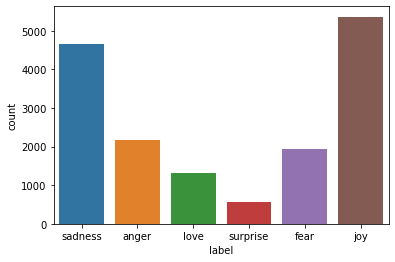

In [7]:
#Target variable count
sns.countplot(data = data_train, x = 'label')

In [8]:
data_train['label'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

In [9]:
def text_clean(clean_text):
    lemmatizer = WordNetLemmatizer()
    reg = clean_text.lower()
    reg = re.sub(r"i'm", "i am", reg)
    reg = re.sub(r"im", "i am", reg)
    reg = re.sub(r"he's", "he is", reg)
    reg = re.sub(r"she's", "she is", reg)
    reg = re.sub(r"[-()\"#/@;:<>`+=~|.!?,]", "", reg)
    reg = re.sub(r"[^\w\s]", "", reg)
    reg = reg.split()
    reg = [lemmatizer.lemmatize(word) for word in reg if word not in stopwords.words('english')]
    reg = " ".join(reg)
    return reg

In [10]:
classes = sorted(list(set(data_train['label'])))

In [11]:
classes

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [12]:
# Output empty array 
output_empty = [0] * len(classes)

In [13]:
output_empty

[0, 0, 0, 0, 0, 0]

In [14]:
# Training data
training = []

for doc in data_train['text']:

    training.append(text_clean(doc))

print(len(training))

16000


In [15]:
training[0]

'didnt feel humiliated'

In [16]:
data_train['text'][0]

'i didnt feel humiliated'

In [17]:
# training data label
training_class = []

for lab in data_train['label']:

    # '1' for current tag and remaining '0' 
    output_row = list(output_empty)
    output_row[classes.index(lab)] = 1

    training_class.append(output_row)

print(len(training_class))

16000


In [18]:
training_class[0]

[0, 0, 0, 0, 1, 0]

In [19]:
token = Tokenizer()
token.fit_on_texts(training)
vocab_size = len(token.word_index) + 1
print(vocab_size)

13469


In [20]:
enc_docs = token.texts_to_sequences(training)

In [21]:
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(training, key=word_count)
len_long_sentence = len(word_tokenize(longest_sentence))
print(len_long_sentence)

35


In [22]:
# pad documents 
max_length = 70
pad_docs = pad_sequences(enc_docs, maxlen=max_length, padding='post')
pad_docs = np.array(pad_docs)

In [23]:
pad_docs[0]

array([ 52,   1, 571,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0])

In [24]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('D:/CW/glove/glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [25]:
# Weight matrix for words in training docs
embed_matrix = zeros((vocab_size, 300))
print(len(embed_matrix[0]))
for word, i in token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embed_matrix[i] = embedding_vector

300


In [26]:
embed_matrix.shape

(13469, 300)

<AxesSubplot:xlabel='label', ylabel='count'>

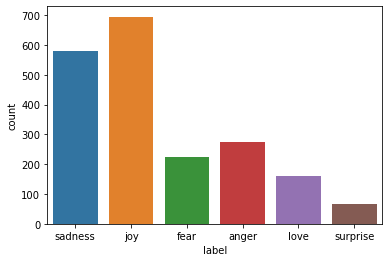

In [27]:
#Target variable test data count
sns.countplot(data = data_test, x = 'label')

In [28]:
classes_test = sorted(list(set(data_test['label'])))

In [29]:
classes_test

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [30]:
# Training data
testing = []

for doc in data_test['text']:

    testing.append(text_clean(doc))

print(len(testing))

2000


In [31]:
testing[1]

'updating blog feel shitty'

In [32]:
data_test['text'][1]

'im updating my blog because i feel shitty'

In [33]:
# testing data label
testing_class = []

for lab in data_test['label']:

    # '1' for current tag and remaining '0' 
    output_row_test = list(output_empty)
    output_row_test[classes_test.index(lab)] = 1

    testing_class.append(output_row_test)

print(len(testing_class))

2000


In [34]:
enc_docs_testing = token.texts_to_sequences(testing)

In [35]:
# pad documents testing
max_length = 70
pad_docs_testing = pad_sequences(enc_docs_testing, maxlen=max_length, padding='post')
pad_docs_testing = np.array(pad_docs_testing)

In [36]:
pad_docs_testing[1]

array([11354,   117,     1,   359,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0])

In [37]:
classes_enc = {"sadness": 0, "anger": 1, "fear": 2, "love": 3, "surprise": 4, "joy": 5}
data_train['label'] = data_train['label'].map(classes_enc)
data_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,1
3,i am ever feeling nostalgic about the fireplac...,3
4,i am feeling grouchy,1


In [38]:
data_test['label'] = data_test['label'].map(classes_enc)
data_test.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,5
4,i was feeling a little vain when i did this one,0


In [39]:
# model 1 with Glove embedding to weights
model = Sequential()
emb = Embedding(vocab_size, 300, weights=[embed_matrix], input_length=70, trainable=False)
model.add(emb)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(training_class[0]), activation='softmax'))

sgd = SGD(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [40]:
# model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 300)           4040700   
                                                                 
 flatten (Flatten)           (None, 21000)             0         
                                                                 
 dense (Dense)               (None, 128)               2688128   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 3

In [41]:
training_padded = np.array(pad_docs)
training_labels = np.array(training_class)
testing_padded = np.array(pad_docs_testing)
testing_labels = np.array(testing_class)

In [42]:
print(training_padded.shape)
print(training_labels.shape)
print(testing_padded.shape)
print(testing_labels.shape)

(16000, 70)
(16000, 6)
(2000, 70)
(2000, 6)


In [43]:
training_labels_enc = data_train['label']
testing_labels_enc = data_test['label']

In [44]:
m = model.fit(training_padded, training_labels_enc, validation_data=(testing_padded, testing_labels_enc), epochs=150, batch_size=30, verbose=1)

Epoch 1/150
534/534 [==============================] - 13s 19ms/step - loss: 1.4883 - accuracy: 0.4296 - val_loss: 1.3214 - val_accuracy: 0.5005
Epoch 2/150
534/534 [==============================] - 10s 19ms/step - loss: 1.2429 - accuracy: 0.5378 - val_loss: 1.1349 - val_accuracy: 0.5730
Epoch 3/150
534/534 [==============================] - 10s 19ms/step - loss: 1.0759 - accuracy: 0.6059 - val_loss: 1.0606 - val_accuracy: 0.5995
Epoch 4/150
534/534 [==============================] - 10s 19ms/step - loss: 0.9467 - accuracy: 0.6572 - val_loss: 1.0245 - val_accuracy: 0.6275
Epoch 5/150
534/534 [==============================] - 10s 19ms/step - loss: 0.8368 - accuracy: 0.7023 - val_loss: 1.0078 - val_accuracy: 0.6340
Epoch 6/150
534/534 [==============================] - 10s 19ms/step - loss: 0.7508 - accuracy: 0.7288 - val_loss: 1.0016 - val_accuracy: 0.6400
Epoch 7/150
534/534 [==============================] - 10s 19ms/step - loss: 0.6677 - accuracy: 0.7650 - val_loss: 1.0036 - val_ac

534/534 [==============================] - 9s 17ms/step - loss: 0.0130 - accuracy: 0.9964 - val_loss: 1.9338 - val_accuracy: 0.6770
Epoch 114/150
534/534 [==============================] - 9s 18ms/step - loss: 0.0141 - accuracy: 0.9959 - val_loss: 1.9393 - val_accuracy: 0.6770
Epoch 115/150
534/534 [==============================] - 9s 17ms/step - loss: 0.0136 - accuracy: 0.9961 - val_loss: 1.9835 - val_accuracy: 0.6775
Epoch 116/150
534/534 [==============================] - 9s 17ms/step - loss: 0.0143 - accuracy: 0.9956 - val_loss: 1.9134 - val_accuracy: 0.6765
Epoch 117/150
534/534 [==============================] - 9s 17ms/step - loss: 0.0133 - accuracy: 0.9957 - val_loss: 1.9388 - val_accuracy: 0.6805
Epoch 118/150
534/534 [==============================] - 9s 17ms/step - loss: 0.0136 - accuracy: 0.9958 - val_loss: 1.9683 - val_accuracy: 0.6855
Epoch 119/150
534/534 [==============================] - 10s 18ms/step - loss: 0.0136 - accuracy: 0.9959 - val_loss: 1.9720 - val_accuracy

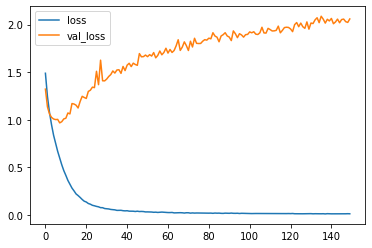

In [45]:
# Plot for loss
plt.plot(m.history['loss'], label='loss')
plt.plot(m.history['val_loss'], label='val_loss')
plt.legend()

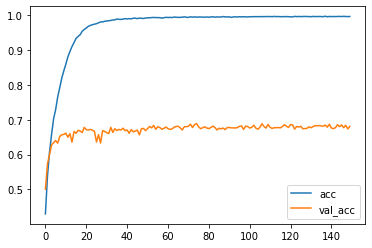

In [46]:
# plot for accuracy
plt.plot(m.history['accuracy'], label='acc')
plt.plot(m.history['val_accuracy'], label='val_acc')
plt.legend()

In [47]:
classes_pred = model.predict(testing_padded)

In [48]:
testing_labels_predict = classes_pred.argmax(axis=-1)

In [49]:
testing_labels_predict

array([0, 0, 0, ..., 5, 5, 2], dtype=int64)

In [50]:
cm = confusion_matrix(testing_labels_enc, testing_labels_predict)

In [51]:
col = ['sadness','anger','fear', 'love', 'surprise', 'joy']

In [52]:
cm_df = pd.DataFrame(cm,
                     index = col, 
                     columns = col)

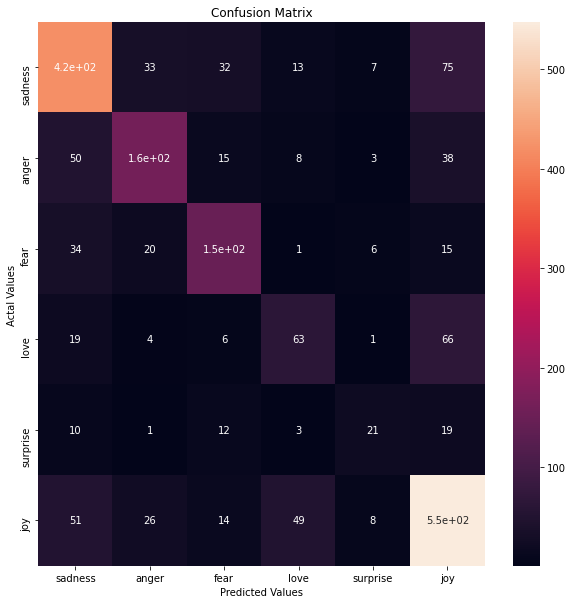

In [53]:
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [54]:
data_test['label'].value_counts()

5    695
0    581
1    275
2    224
3    159
4     66
Name: label, dtype: int64

In [55]:
# model 2 without Glove embedding to weights
model_1 = Sequential()
model_1.add(Embedding(vocab_size, 300, input_length=70))
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(len(training_class[0]), activation='softmax'))

model_1.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [56]:
m_1 = model_1.fit(training_padded, training_labels_enc, validation_data=(testing_padded, testing_labels_enc), epochs=150, batch_size=30, verbose=1)

Epoch 1/150
534/534 [==============================] - 14s 25ms/step - loss: 1.6015 - accuracy: 0.3286 - val_loss: 1.5614 - val_accuracy: 0.3475
Epoch 2/150
534/534 [==============================] - 13s 24ms/step - loss: 1.5840 - accuracy: 0.3305 - val_loss: 1.5591 - val_accuracy: 0.3475
Epoch 3/150
534/534 [==============================] - 13s 25ms/step - loss: 1.5799 - accuracy: 0.3364 - val_loss: 1.5596 - val_accuracy: 0.3475
Epoch 4/150
534/534 [==============================] - 13s 25ms/step - loss: 1.5766 - accuracy: 0.3332 - val_loss: 1.5572 - val_accuracy: 0.3530
Epoch 5/150
534/534 [==============================] - 13s 25ms/step - loss: 1.5766 - accuracy: 0.3379 - val_loss: 1.5576 - val_accuracy: 0.3560
Epoch 6/150
534/534 [==============================] - 13s 25ms/step - loss: 1.5757 - accuracy: 0.3386 - val_loss: 1.5568 - val_accuracy: 0.3465
Epoch 7/150
534/534 [==============================] - 13s 25ms/step - loss: 1.5729 - accuracy: 0.3408 - val_loss: 1.5552 - val_ac

534/534 [==============================] - 12s 22ms/step - loss: 0.0204 - accuracy: 0.9951 - val_loss: 0.8256 - val_accuracy: 0.8400
Epoch 114/150
534/534 [==============================] - 12s 23ms/step - loss: 0.0213 - accuracy: 0.9950 - val_loss: 0.8242 - val_accuracy: 0.8410
Epoch 115/150
534/534 [==============================] - 12s 23ms/step - loss: 0.0203 - accuracy: 0.9949 - val_loss: 0.8051 - val_accuracy: 0.8430
Epoch 116/150
534/534 [==============================] - 12s 22ms/step - loss: 0.0203 - accuracy: 0.9950 - val_loss: 0.8300 - val_accuracy: 0.8370
Epoch 117/150
534/534 [==============================] - 12s 23ms/step - loss: 0.0186 - accuracy: 0.9949 - val_loss: 0.8060 - val_accuracy: 0.8365
Epoch 118/150
534/534 [==============================] - 12s 22ms/step - loss: 0.0165 - accuracy: 0.9958 - val_loss: 0.8257 - val_accuracy: 0.8410
Epoch 119/150
534/534 [==============================] - 12s 22ms/step - loss: 0.0180 - accuracy: 0.9954 - val_loss: 0.8277 - val_ac

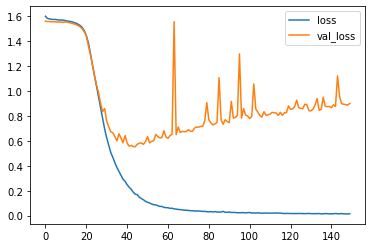

In [57]:
# Plot for loss
plt.plot(m_1.history['loss'], label='loss')
plt.plot(m_1.history['val_loss'], label='val_loss')
plt.legend()

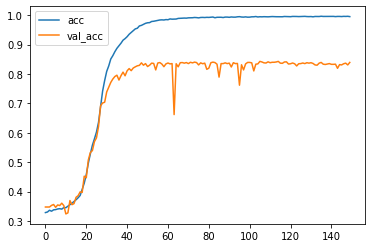

In [58]:
# plot for accuracy
plt.plot(m_1.history['accuracy'], label='acc')
plt.plot(m_1.history['val_accuracy'], label='val_acc')
plt.legend()

In [59]:
classes_pred_1 = model_1.predict(testing_padded)
testing_labels_predict_1 = classes_pred_1.argmax(axis=-1)

In [60]:
cm_1 = confusion_matrix(testing_labels_enc, testing_labels_predict_1)
cm_df_1 = pd.DataFrame(cm_1,
                     index = col, 
                     columns = col)

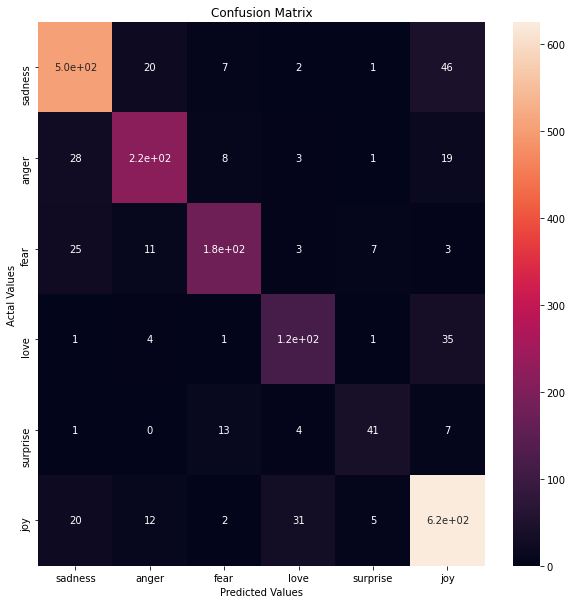

In [61]:
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df_1, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [77]:
# define model
model_2 = Sequential()
model_2.add(Embedding(vocab_size, 300, input_length=70))
model_2.add(Bidirectional(LSTM(64, activation='relu')))
model_2.add(Dropout(0.2))
model_2.add(Dense(len(training_class[0]), activation='softmax'))

model_2.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [78]:
m_2 = model_2.fit(training_padded, training_labels_enc, validation_data=(testing_padded, testing_labels_enc), epochs=150, batch_size=30, verbose=1)

Epoch 1/150
534/534 [==============================] - 70s 127ms/step - loss: 1.6405 - accuracy: 0.3257 - val_loss: 1.5661 - val_accuracy: 0.3475
Epoch 2/150
534/534 [==============================] - 68s 127ms/step - loss: 1.5803 - accuracy: 0.3349 - val_loss: 1.5606 - val_accuracy: 0.3475
Epoch 3/150
534/534 [==============================] - 69s 128ms/step - loss: 1.5789 - accuracy: 0.3327 - val_loss: 1.5596 - val_accuracy: 0.3475
Epoch 4/150
534/534 [==============================] - 70s 132ms/step - loss: 1.5772 - accuracy: 0.3325 - val_loss: 1.5583 - val_accuracy: 0.3475
Epoch 5/150
534/534 [==============================] - 68s 128ms/step - loss: 1.5766 - accuracy: 0.3334 - val_loss: 1.5587 - val_accuracy: 0.3475
Epoch 6/150
534/534 [==============================] - 70s 131ms/step - loss: 1.5761 - accuracy: 0.3342 - val_loss: 1.5581 - val_accuracy: 0.3475
Epoch 7/150
534/534 [==============================] - 69s 129ms/step - loss: 1.5759 - accuracy: 0.3368 - val_loss: 1.5576 -

Epoch 57/150
534/534 [==============================] - 66s 124ms/step - loss: 0.8924 - accuracy: 0.6826 - val_loss: 0.9736 - val_accuracy: 0.6505
Epoch 58/150
534/534 [==============================] - 67s 126ms/step - loss: 0.8030 - accuracy: 0.7156 - val_loss: 0.7810 - val_accuracy: 0.7385
Epoch 59/150
534/534 [==============================] - 72s 135ms/step - loss: 0.7704 - accuracy: 0.7296 - val_loss: 0.7935 - val_accuracy: 0.7435
Epoch 60/150
534/534 [==============================] - 72s 135ms/step - loss: 0.7375 - accuracy: 0.7447 - val_loss: 0.7651 - val_accuracy: 0.7555
Epoch 61/150
534/534 [==============================] - 70s 130ms/step - loss: 0.7054 - accuracy: 0.7588 - val_loss: 0.7288 - val_accuracy: 0.7645
Epoch 62/150
534/534 [==============================] - 69s 130ms/step - loss: 0.6847 - accuracy: 0.7653 - val_loss: 0.7937 - val_accuracy: 0.7450
Epoch 63/150
534/534 [==============================] - 70s 131ms/step - loss: 0.6554 - accuracy: 0.7769 - val_loss: 0

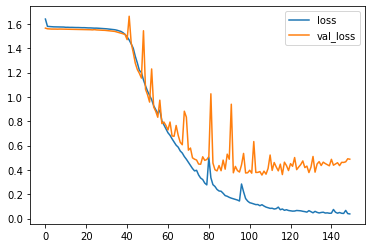

In [79]:
# Plot for loss
plt.plot(m_2.history['loss'], label='loss')
plt.plot(m_2.history['val_loss'], label='val_loss')
plt.legend()

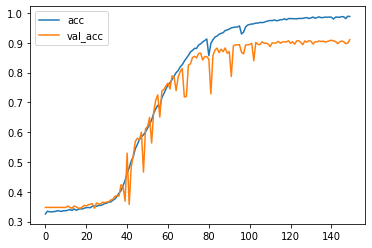

In [80]:
# plot for accuracy
plt.plot(m_2.history['accuracy'], label='acc')
plt.plot(m_2.history['val_accuracy'], label='val_acc')
plt.legend()

In [81]:
classes_pred_2 = model_2.predict(testing_padded)
testing_labels_predict_2 = classes_pred_2.argmax(axis=-1)

In [82]:
cm_2 = confusion_matrix(testing_labels_enc, testing_labels_predict_2)
cm_df_2 = pd.DataFrame(cm_2,
                     index = col, 
                     columns = col)

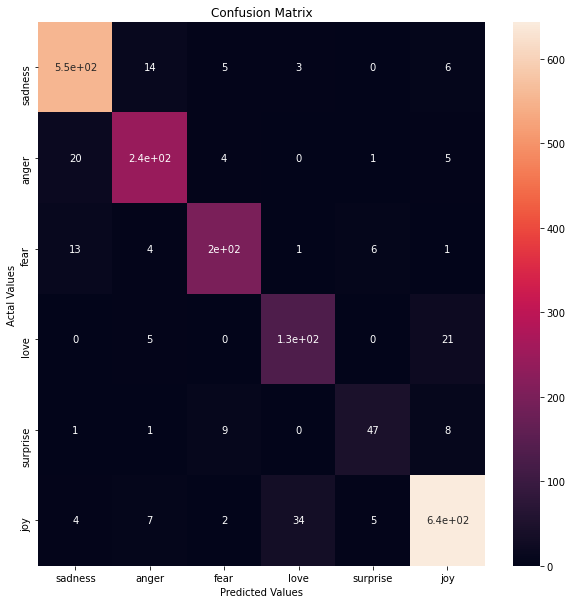

In [83]:
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df_2, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()